In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy
from decimal import *
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
import threading
import numpy as np
import datetime

In [3]:
import scipy.stats as ss

In [4]:
import itertools

In [5]:
def setupStake(
        # Number of nodes in the network. This number can be changed to test with small and large network size
        numNodes=5,
        # the minimum number of channels a node can open
        minChannelsPerNode=2,
        # the maximum number of channels a node can open 
        maxChannelsPerNode=10,
        minFundsPerNode=10,
        maxFundsPerNode=100,
        tokensPerTicket=0.1
    ):

    stake = [[0 for i in range(numNodes)] for j in range(numNodes)]
    for x in range(numNodes):
        # each node is given a random funding amount
        myFunds = numpy.random.rand() * (maxFundsPerNode - minFundsPerNode) + minFundsPerNode

        # get random number of channels per node
        myChannels = int(numpy.random.rand() * (maxChannelsPerNode - minChannelsPerNode + 1) + minChannelsPerNode)

        # This value represents the amount each node stakes in their channel
        # It is computed as the number of funds a node has divided by number of channels they open
        stakePerChannel = myFunds / myChannels
        stakePerChannel = int(stakePerChannel / tokensPerTicket) * tokensPerTicket

        # fund channels by writing into stake matrix
        for c in range(myChannels):
            # TODO: this does not prevent a node from opening a channel to the same counterparty multiple times
            counterparty = int(numpy.random.rand() * (numNodes - 1))

            # cannot open channel to self - keep diagonal of matrix at 0
            if counterparty >= x:
                counterparty = counterparty + 1
            stake[x][counterparty] = stakePerChannel
            stake = [[Decimal(i) for i in j] for j in stake]

    return stake

In [6]:
def printArray2d(a):
    for row in range(len(a)):
        for col in range (len(a[row])):
            if format == 1:
                print("{:4.1f}".format(a[row][col]), end = " ")
            else:
                print("{:4.0f}".format(a[row][col]), end = " ")

        print()

In [7]:
initial_stake = setupStake()
printArray2d(initial_stake)

   0    5    5    0    5 
  44    0    0    0   44 
   0    6    0    6    6 
   0   12   12    0   12 
  31    0    0   31    0 


In [8]:
def calcImportance(stake):

    # get total stake per node
    stakePerNode = [Decimal(sum(e)) for e in stake]

    totalStake = sum(stakePerNode)

    n = len(stake)
    weight = [0] * n
    importance = [0] * n
    for x in range(n):
        for y in range(n):
            # weight of a node is 0 if its stake is equal to 0
            #weight(channel) = sqrt(balance(channel) / stake(channel.source) * stake(channel.destination))
            weight[y] += 0 if stakePerNode[y]==0 else numpy.sqrt(stake[y][x]/stakePerNode[y] * stakePerNode[x])

    #print("Weighted downstream stake per node p(n) = ", weight)
    importanceList = numpy.array(weight) * numpy.array(stakePerNode)
    return importanceList;

In [9]:
initial_importance = calcImportance(initial_stake)
initial_importance

array([Decimal('186.4036088884399289129449228'),
       Decimal('728.4246762029607795074628267'),
       Decimal('244.5422910742511681009157686'),
       Decimal('432.4563726211806880571243071'),
       Decimal('429.7984863499074717731715496')], dtype=object)

In [10]:
#MODEL1 = based on stake

In [11]:
numNodes=5
def recalculating_stakes_with_stakes(stake, importance):
    #calculating sum of the original stake
    sum_stake = sum([sum(stake[li]) for li in range(numNodes)])
    #creating an empy stake matrix with the original shape
    stake_mod = [[0 for i in range(numNodes)] for j in range(numNodes)]
    #populating it with recalculation
    for p in range(numNodes):
        for r in range(numNodes):
            if p == r:
                stake_mod[p][r] = 0
            else:
                stake_mod[p][r] = sum(stake[r])/(sum_stake-sum(stake[p]))*sum(stake[p])
    
    return stake_mod

In [12]:
based_on_stake = recalculating_stakes_with_stakes(initial_stake, initial_importance)
printArray2d(based_on_stake)

   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 


In [13]:
based_on_stake_importance = calcImportance(based_on_stake)
based_on_stake_importance

array([Decimal('213.6644565668328558017139630'),
       Decimal('999.9454625128313773869401199'),
       Decimal('258.5421513022586746848364446'),
       Decimal('470.8942811290025319051612945'),
       Decimal('776.1303936839480007641053019')], dtype=object)

In [14]:
def iterating_recalculating_stakes(stake, importance):
    iterated_stakes = []
    iterated_importance = []
    for _ in range(100):
        printArray2d(stake)
        print(" ")
        a = recalculating_stakes_with_stakes(stake, importance)
        #creating a list of stakes
        iterated_stakes.append(a)
        #recalculating the importance and creating list with it
        importance = calcImportance(a)
        iterated_importance.append(importance)
        stake = a 
    return iterated_stakes

In [33]:
def iterating_recalculating_stakes(stake, importance):   
    iterated_stakes = []
    iterated_importance = []
    difference_between_stake_matrix = []
    added_list =[]
    incoming_stake = []
    incoming_stake_sum = []
    
    for _ in range(100):
        printArray2d(stake)
        print(" ")
        a = recalculating_stakes_with_stakes(stake, importance)
        iterated_stakes.append(a)
        b = calcImportance(a)
        iterated_importance.append(importance)
        df_stake = pd.DataFrame(stake)
        df_a = pd.DataFrame(a)
        c = df_stake - df_a
        difference_between_stake_matrix.append(c)
        stake = a
        importance = b 
    
    input_stake_matrix = difference_between_stake_matrix
    
    for k in range(len(input_stake_matrix)):
        sum_of_difference_by_column = (abs(input_stake_matrix[k])).sum()
        total_sum_of_difference = sum(sum_of_difference_by_column)
        added_list.append(total_sum_of_difference)
        incoming_stake.append(sum_of_difference_by_column)
        
    input_incoming_stake = (pd.DataFrame(incoming_stake)).T
    input_incoming_stake["sum"] = input_incoming_stake.sum(axis=1)
          
    df = pd.DataFrame(added_list)
    plt.scatter(df.index,df[0])
    plt.show()
    
    df_2 = pd.DataFrame(input_incoming_stake)
    plt.scatter(df_2.index,df_2["sum"])
    plt.show()
    
    return iterated_stakes

   0    5    5    0    5 
  44    0    0    0   44 
   0    6    0    6    6 
   0   12   12    0   12 
  31    0    0   31    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6

   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6 
   3   17    3    0   12 
   6   35    7   14    0 
 
   0    6    1    3    5 
  10    0   12   23   42 
   1    8    0    3    6

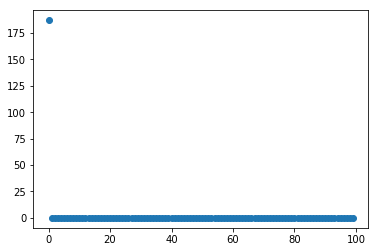

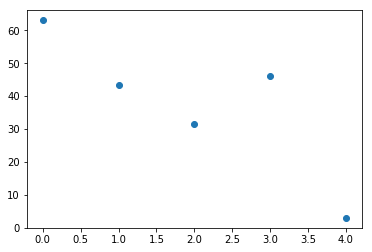

[[[0,
   Decimal('6.476096599310005008921957195'),
   Decimal('1.352883193691473635632061044'),
   Decimal('2.572695909314933561456847060'),
   Decimal('4.598324297683587793989134700')],
  [Decimal('10.08442056792018449824557287'),
   0,
   Decimal('12.30299309286262616267136573'),
   Decimal('23.39585571757483090209444062'),
   Decimal('41.81673062164236696350144987')],
  [Decimal('1.375250501002004020455830453'),
   Decimal('8.031462925851704261201452519'),
   0,
   Decimal('3.190581162324649718327227987'),
   Decimal('5.702705410821643598736644503')],
  [Decimal('2.850901146914254653086054821'),
   Decimal('16.64926269797924879457224040'),
   Decimal('3.478099399235390980618051929'),
   0,
   Decimal('11.82173675587110983498006741')],
  [Decimal('5.992292870905587388648141962'),
   Decimal('34.99499036608863375592928503'),
   Decimal('7.310597302504817252817758688'),
   Decimal('13.90211946050096444477575734'),
   0]],
 [[0,
   Decimal('6.476096599310005008921957192'),
   Decimal('1

In [34]:
based_on_stake_iteration = iterating_recalculating_stakes(initial_stake, initial_importance)
based_on_stake_iteration

In [35]:
#MODEL2_based on importance

In [36]:
numNodes=5
def recalculating_stakes_with_importance(stake, importance):
    #calculating sum of the original stake
    sum_stake = sum([sum(stake[li]) for li in range(numNodes)])
    #creating an empy stake matrix with the original shape
    stake_mod = [[0 for i in range(numNodes)] for j in range(numNodes)]
    stake_mod_i = [[0 for i in range(numNodes)] for j in range(numNodes)]
    #populating it with recalculation
    for p in range(numNodes):
        for r in range(numNodes):
            if p == r:
                stake_mod[p][r] = 0
            else:
                stake_mod[p][r] = importance[r]/(sum(importance)-importance[p])*sum(stake[p])
                
    return stake_mod

 for y in range(numNodes):
        for z in range(numNodes):
            if y == z:
                stake_mod_i[y][z] = 0
            else:
                stake_mod_i[y][z] = stake_mod[y][z]/sum(stake_mod[y])*sum(stake[y])
    

In [37]:
based_on_importance = recalculating_stakes_with_importance(initial_stake, initial_importance)
printArray2d(based_on_importance)

   0    6    2    4    4 
  13    0   17   29   29 
   2    8    0    4    4 
   4   16    5    0    9 
   7   28   10   17    0 


In [38]:
based_on_importance_importance = calcImportance(based_on_importance)
based_on_importance_importance

array([Decimal('212.0763495460397985663404112'),
       Decimal('988.8902805379605843021238227'),
       Decimal('256.8458199718418969138224599'),
       Decimal('467.8053343641808763632536444'),
       Decimal('771.7871163179788982796360369')], dtype=object)

In [39]:
def iterating_recalculating_stakes_with_importance(stake, importance):
    iterated_stakes = []
    iterated_importance = []
    difference_between_stake_matrix = []
    added_list =[]
    incoming_stake = []
    incoming_stake_sum = []
    
    for _ in range(100):
        
        a = recalculating_stakes_with_importance(stake, importance)
        iterated_stakes.append(a)
        b = calcImportance(a)
        iterated_importance.append(importance)
        df_stake = pd.DataFrame(stake)
        df_a = pd.DataFrame(a)
        c = df_stake - df_a
        difference_between_stake_matrix.append(c)
        stake = a
        importance = b 
    
    input_stake_matrix = difference_between_stake_matrix
    
    for k in range(len(input_stake_matrix)):
        sum_of_difference_by_column = (abs(input_stake_matrix[k])).sum()
        total_sum_of_difference = sum(sum_of_difference_by_column)
        added_list.append(total_sum_of_difference)
        incoming_stake.append(sum_of_difference_by_column)
        
    input_incoming_stake = (pd.DataFrame(incoming_stake)).T
    input_incoming_stake["sum"] = input_incoming_stake.sum(axis=1)
          
    df = pd.DataFrame(added_list)
    plt.scatter(df.index,df[0])
    plt.show()
    
    df_2 = pd.DataFrame(input_incoming_stake)
    plt.scatter(df_2.index,df_2["sum"])
    plt.show()
    
    return input_incoming_stake

for k in range(numNodes):
        difference_between_stake_matrix = abs(difference_between_stake_matrix[k+1]-difference_between_stake_matrix[k])
        sum_of_difference_by_row = difference_between_stake_matrix.sum()
        total_sum_of_difference = sum(sum_of_difference_by_row)
        added_list.append(total_sum_of_difference)

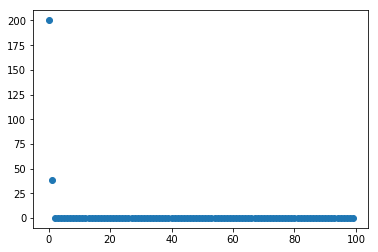

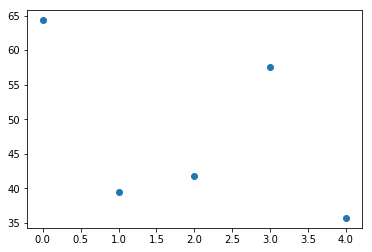

In [40]:
h = iterating_recalculating_stakes_with_importance(initial_stake, initial_importance)

In [41]:
h

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,sum
0,60.991030,3.287486,0.031752,0.000350,0.000004,3.970571e-08,4.238457e-10,4.527236e-12,4.834793e-14,5.163532e-16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.310622
1,35.168976,4.096832,0.168464,0.001839,0.000020,2.088689e-07,2.229653e-09,2.381537e-11,2.543342e-13,2.716267e-15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.436131
2,35.366632,6.449521,0.038587,0.000415,0.000004,4.734600e-08,5.056939e-10,5.400581e-12,5.767749e-14,6.159836e-16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.855159
3,48.677361,8.752688,0.062698,0.000683,0.000007,7.786258e-08,8.312252e-10,8.878831e-12,9.481749e-14,1.012662e-15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.493438
4,20.035211,15.598081,0.104795,0.001099,0.000012,1.271559e-07,1.359958e-09,1.451890e-11,1.550713e-13,1.656109e-15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.739198


In [42]:
initial_importance

array([Decimal('186.4036088884399289129449228'),
       Decimal('728.4246762029607795074628267'),
       Decimal('244.5422910742511681009157686'),
       Decimal('432.4563726211806880571243071'),
       Decimal('429.7984863499074717731715496')], dtype=object)

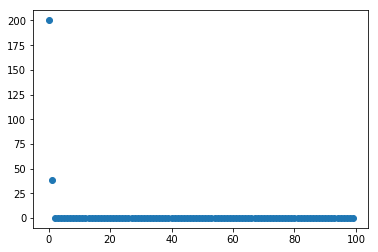

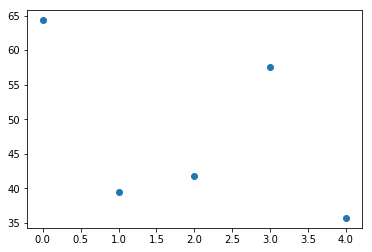

In [46]:
calculating_difference = iterating_recalculating_stakes_with_importance(initial_stake, initial_importance)

In [47]:
#MODEL3: limited number of nodes 

In [51]:
numNodes=5
def recalculating_stakes_limited(stake, importance):
    #calculating sum of the original stake
    sum_stake = sum([sum(stake[li]) for li in range(numNodes)])
    #creating an empy stake matrix with the original shape
    stake_mod = [[0 for i in range(numNodes)] for j in range(numNodes)]
    stake_mod_i = [[0 for i in range(numNodes)] for j in range(numNodes)]
    #populating it with recalculation
    for p in range(numNodes):
        for r in range(numNodes):
            if p == r:
                stake_mod[p][r] = 0     
            elif stake[p][r] == 0:
                stake_mod[p][r] = 0
            else:
                stake_mod[p][r] = importance[r]/(sum(importance)-importance[p])*sum(stake[p])
    
    for l in range(numNodes):
        for m in range(numNodes):
            if l == m:
                stake_mod_i[l][m] = 0     
            elif stake[l][m] == 0:
                stake_mod_i[l][m] = 0
            else:
                stake_mod_i[l][m] = stake_mod[l][m]/sum(stake_mod[l])*sum(stake[l])   
    
    return stake_mod_i

In [52]:
initial_stake

[[Decimal('0'), Decimal('5'), Decimal('5'), Decimal('0'), Decimal('5')],
 [Decimal('43.80000000000000426325641456060111522674560546875'),
  Decimal('0'),
  Decimal('0'),
  Decimal('0'),
  Decimal('43.80000000000000426325641456060111522674560546875')],
 [Decimal('0'),
  Decimal('6.10000000000000053290705182007513940334320068359375'),
  Decimal('0'),
  Decimal('6.10000000000000053290705182007513940334320068359375'),
  Decimal('6.10000000000000053290705182007513940334320068359375')],
 [Decimal('0'),
  Decimal('11.60000000000000142108547152020037174224853515625'),
  Decimal('11.60000000000000142108547152020037174224853515625'),
  Decimal('0'),
  Decimal('11.60000000000000142108547152020037174224853515625')],
 [Decimal('31.10000000000000142108547152020037174224853515625'),
  Decimal('0'),
  Decimal('0'),
  Decimal('31.10000000000000142108547152020037174224853515625'),
  Decimal('0')]]

In [53]:
limited2 = recalculating_stakes_limited(initial_stake, initial_importance)
limited2

[[0,
  Decimal('7.789163979475103098604632642'),
  Decimal('2.614930640492394373591064714'),
  0,
  Decimal('4.595905380032502527804302642')],
 [Decimal('26.49935186006027409957859008'),
  0,
  0,
  0,
  Decimal('61.10064813993973442693423904')],
 [0,
  Decimal('8.380174183265407385448947400'),
  0,
  Decimal('4.975201757468815800125149802'),
  Decimal('4.944624059265778413147058249')],
 [0,
  Decimal('18.07086043238224140257630103'),
  Decimal('6.066639085942355689939258586'),
  0,
  Decimal('10.66250048167540717074085494')],
 [Decimal('18.73493975903614383053638638'),
  0,
  0,
  Decimal('43.46506024096385901163455666'),
  0]]

In [54]:
sum(initial_importance)

Decimal('2021.625435136740036351619375')

numNodes=5
def recalculating_stakes_limited(stake, importance):
    #calculating sum of the original stake
    sum_stake = sum([sum(stake[li]) for li in range(numNodes)])
    #creating an empy stake matrix with the original shape
    stake_mod = [[0 for i in range(numNodes)] for j in range(numNodes)]
    stake_mod_i = [[0 for i in range(numNodes)] for j in range(numNodes)]
    #populating it with recalculation
    for p in range(numNodes):
        for r in range(numNodes):
            if p == r:
                stake_mod[p][r] = 0     
            elif stake[p][r] == 0:
                stake_mod[p][r] = 0
            else:
                stake_mod[p][r] = importance[r]/(sum_stake-sum(stake[p])) * sum(stake[p])
    
    for l in range(numNodes):
        for m in range(numNodes):
            if l == m:
                stake_mod_i[l][m] = 0     
            elif stake[l][m] == 0:
                stake_mod_i[l][m] = 0
            else:
                stake_mod_i[l][m] = stake_mod[l][m]/sum(stake_mod[l])*sum(stake[l])   
    
    return stake_mod_i

In [56]:
initial_stake

[[Decimal('0'), Decimal('5'), Decimal('5'), Decimal('0'), Decimal('5')],
 [Decimal('43.80000000000000426325641456060111522674560546875'),
  Decimal('0'),
  Decimal('0'),
  Decimal('0'),
  Decimal('43.80000000000000426325641456060111522674560546875')],
 [Decimal('0'),
  Decimal('6.10000000000000053290705182007513940334320068359375'),
  Decimal('0'),
  Decimal('6.10000000000000053290705182007513940334320068359375'),
  Decimal('6.10000000000000053290705182007513940334320068359375')],
 [Decimal('0'),
  Decimal('11.60000000000000142108547152020037174224853515625'),
  Decimal('11.60000000000000142108547152020037174224853515625'),
  Decimal('0'),
  Decimal('11.60000000000000142108547152020037174224853515625')],
 [Decimal('31.10000000000000142108547152020037174224853515625'),
  Decimal('0'),
  Decimal('0'),
  Decimal('31.10000000000000142108547152020037174224853515625'),
  Decimal('0')]]

In [57]:
sum(initial_stake[4])-sum(limited2[4])

Decimal('0E-26')

In [58]:
limited = recalculating_stakes_limited(initial_stake, initial_importance)

In [59]:
printArray2d(initial_stake)

   0    5    5    0    5 
  44    0    0    0   44 
   0    6    0    6    6 
   0   12   12    0   12 
  31    0    0   31    0 


In [60]:
printArray2d(limited2)

   0    8    3    0    5 
  26    0    0    0   61 
   0    8    0    5    5 
   0   18    6    0   11 
  19    0    0   43    0 


In [61]:
def iterating_recalculating_stakes_limited(stake, importance):
    iterated_stakes = []
    iterated_importance = []
    for _ in range(100):
        printArray2d(stake)
        print(" ")
        a = recalculating_stakes_limited(stake, importance)
        iterated_stakes.append(a)
        b = calcImportance(a)
        iterated_importance.append(importance)
        stake = a 
        importance = b
    return iterated_stakes

In [62]:
iteration = iterating_recalculating_stakes_limited(initial_stake, initial_importance)
iteration

   0    5    5    0    5 
  44    0    0    0   44 
   0    6    0    6    6 
   0   12   12    0   12 
  31    0    0   31    0 
 
   0    8    3    0    5 
  26    0    0    0   61 
   0    8    0    5    5 
   0   18    6    0   11 
  19    0    0   43    0 
 
   0    8    3    0    5 
  27    0    0    0   61 
   0    8    0    5    5 
   0   18    6    0   11 
  19    0    0   43    0 
 
   0    8    3    0    5 
  27    0    0    0   61 
   0    8    0    5    5 
   0   18    6    0   11 
  19    0    0   43    0 
 
   0    8    3    0    5 
  27    0    0    0   61 
   0    8    0    5    5 
   0   18    6    0   11 
  19    0    0   43    0 
 
   0    8    3    0    5 
  27    0    0    0   61 
   0    8    0    5    5 
   0   18    6    0   11 
  19    0    0   43    0 
 
   0    8    3    0    5 
  27    0    0    0   61 
   0    8    0    5    5 
   0   18    6    0   11 
  19    0    0   43    0 
 
   0    8    3    0    5 
  27    0    0    0   61 
   0    8    0    5    5

[[[0,
   Decimal('7.789163979475103098604632642'),
   Decimal('2.614930640492394373591064714'),
   0,
   Decimal('4.595905380032502527804302642')],
  [Decimal('26.49935186006027409957859008'),
   0,
   0,
   0,
   Decimal('61.10064813993973442693423904')],
  [0,
   Decimal('8.380174183265407385448947400'),
   0,
   Decimal('4.975201757468815800125149802'),
   Decimal('4.944624059265778413147058249')],
  [0,
   Decimal('18.07086043238224140257630103'),
   Decimal('6.066639085942355689939258586'),
   0,
   Decimal('10.66250048167540717074085494')],
  [Decimal('18.73493975903614383053638638'),
   0,
   0,
   Decimal('43.46506024096385901163455666'),
   0]],
 [[0,
   Decimal('7.900611785921202073246708940'),
   Decimal('2.557847224598832780975336060'),
   0,
   Decimal('4.541540989479965145777954996')],
  [Decimal('26.79637816288449208105216044'),
   0,
   0,
   0,
   Decimal('60.80362183711551644546066868')],
  [0,
   Decimal('8.462180708669139029299178085'),
   0,
   Decimal('4.973469340

In [63]:
limited = recalculating_stakes_limited(initial_stake, initial_importance)

In [64]:
k = []
for j in range(5):
    l = [i for i in range(5)]
    k.append(l)

In [65]:
o = []
for g in range(5):
    h = [g]*5
    o.append(h)

In [66]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [67]:
df_00 = pd.DataFrame(flatten(o))

In [68]:
df_0 = pd.DataFrame(flatten(k))
df_0

,0
0,0
1,1
2,2
3,3
4,4
5,0
6,1
7,2
8,3
9,4


In [69]:
df = pd.DataFrame(flatten(initial_stake))

In [70]:
df_1 = pd.concat([df_0, df], axis=1)
df_1

,0,0
0,0,0
1,1,5
2,2,5
3,3,0
4,4,5
5,0,43.8000000000000042632564145606011152267456054...
6,1,0
7,2,0
8,3,0
9,4,43.8000000000000042632564145606011152267456054...


In [71]:
df_2 = pd.concat([df_00, df_1], axis=1)
df_2.head(30)

,0,0,0
0,0,0,0
1,0,1,5
2,0,2,5
3,0,3,0
4,0,4,5
5,1,0,43.8000000000000042632564145606011152267456054...
6,1,1,0
7,1,2,0
8,1,3,0
9,1,4,43.8000000000000042632564145606011152267456054...


iteration_recalculating_stakes(initial_stake)

In [72]:
import networkx as nx

In [73]:
pip install pyvis

Note: you may need to restart the kernel to use updated packages.


In [74]:
df_2.columns=['source', 'target', 'weight']

In [75]:
df_2['weight2'] = df_2['weight'].apply(lambda x: float(x))
df_2

,source,target,weight,weight2
0,0,0,0,0.0
1,0,1,5,5.0
2,0,2,5,5.0
3,0,3,0,0.0
4,0,4,5,5.0
5,1,0,43.8000000000000042632564145606011152267456054...,43.8
6,1,1,0,0.0
7,1,2,0,0.0
8,1,3,0,0.0
9,1,4,43.8000000000000042632564145606011152267456054...,43.8


In [76]:
df_3 = df_2[df_2['weight2'] > 0]

In [77]:
G = nx.from_pandas_edgelist(df_3, source='target', target='source', edge_attr='weight2')

In [78]:
from pyvis.network import Network

In [79]:
net = Network(notebook=True, height='700px', width='700', directed=True, bgcolor="#222222", font_color='white')

In [80]:
net.from_nx(G)

In [81]:
initial_stake

[[Decimal('0'), Decimal('5'), Decimal('5'), Decimal('0'), Decimal('5')],
 [Decimal('43.80000000000000426325641456060111522674560546875'),
  Decimal('0'),
  Decimal('0'),
  Decimal('0'),
  Decimal('43.80000000000000426325641456060111522674560546875')],
 [Decimal('0'),
  Decimal('6.10000000000000053290705182007513940334320068359375'),
  Decimal('0'),
  Decimal('6.10000000000000053290705182007513940334320068359375'),
  Decimal('6.10000000000000053290705182007513940334320068359375')],
 [Decimal('0'),
  Decimal('11.60000000000000142108547152020037174224853515625'),
  Decimal('11.60000000000000142108547152020037174224853515625'),
  Decimal('0'),
  Decimal('11.60000000000000142108547152020037174224853515625')],
 [Decimal('31.10000000000000142108547152020037174224853515625'),
  Decimal('0'),
  Decimal('0'),
  Decimal('31.10000000000000142108547152020037174224853515625'),
  Decimal('0')]]

In [82]:
net.show("example.html")

In [83]:
net.show("match.html")